# regression example - house price dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
import copy
import dill
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

**Gators** imports

In [9]:
from gators.util import util
# sampling
from gators.sampling import UnsupervisedSampling
# data cleaninng
from gators.data_cleaning import (
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    WOEEncoder, 
    TargetEncoder,
    OrdinalEncoder, 
)
# binning
from gators.binning import (
    BinRareCategories,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
    PolynomialFeatures,
    PolynomialObjectFeatures,
)
# feature selection
from gators.feature_selection import (
    InformationValue,
    SelectFromModel,
)
# model building
from gators.model_building import (
    TrainTestSplit,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
    LGBMTreeliteDumper,
)
# # pipeline
from gators.pipeline import Pipeline

#### Pipeline composed of
* Bin rare events
* Imputers
* Ordinal Encoder
* Polynomial Features (a subset of the input columns)

## offline pipeline - feature selection

In [77]:
model = LGBMRegressor(
    random_state=0, n_estimators=100, max_depth=3)
k = 50
polynomial_columns = ['GrLivArea', 'OverallQual','BsmtFinSF1', 'LotArea','TotalBsmtSF']
steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('OrdinalEncoder', OrdinalEncoder()),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=0)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('SelectFromModel', SelectFromModel(model=model, k=k)),
]

In [78]:
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)
selected_columns = pipe.steps[-1][1].selected_columns

In [57]:
pd.Series(
    pipe.steps[-1][1].feature_importances_,
    index=pipe.steps[-2][1].columns_
).sort_values(ascending=False).iloc[:50]

GrLivArea        67.0
LotArea          38.0
BsmtFinSF1       31.0
OverallQual      31.0
TotalBsmtSF      31.0
GarageArea       24.0
OverallCond      24.0
YearBuilt        22.0
LotFrontage      21.0
YearRemodAdd     18.0
GarageYrBlt      16.0
1stFlrSF         15.0
OpenPorchSF      14.0
Fireplaces       11.0
ScreenPorch      11.0
WoodDeckSF       11.0
MasVnrArea       10.0
GarageCars       10.0
Condition1       10.0
MoSold            9.0
TotRmsAbvGrd      8.0
2ndFlrSF          7.0
BsmtUnfSF         7.0
BsmtExposure      7.0
Exterior2nd       7.0
YrSold            7.0
GarageType        6.0
Functional        6.0
MSZoning          5.0
RoofMatl          5.0
KitchenAbvGr      5.0
KitchenQual       5.0
BsmtFinType1      5.0
BsmtFullBath      4.0
SaleType          4.0
PavedDrive        3.0
SaleCondition     3.0
FireplaceQu       3.0
FullBath          3.0
BsmtFinSF2        3.0
LotShape          3.0
HalfBath          2.0
CentralAir        2.0
Exterior1st       2.0
BedroomAbvGr      1.0
GarageFini

In [102]:
model = XGBRegressor(
    random_state=0, n_estimators=100, max_depth=2, gamma=1, colsample_bytree=0.6)
polynomial_columns = ['GrLivArea', 'OverallQual','BsmtFinSF1',
                      'LotArea','TotalBsmtSF']
steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('OrdinalEncoder', OrdinalEncoder()),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=0)),
    ('TreeBinning', TreeBinning(tree=DecisionTreeRegressor(max_depth=3, min_samples_split=50))),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        degree=2, 
        columns=polynomial_columns)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('TargetEncoder', TargetEncoder()),
    ('ESTIMATOR', model),
]

In [103]:
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train[selected_columns].copy(), y_train)
r2_score(y_train, pipe.predict(X_train[selected_columns].copy())), r2_score(y_test, pipe.predict(X_test[selected_columns].copy()))

[17:49:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.9420080201002993, 0.8747080831433823)

### pandas

In [14]:
data = pd.read_parquet('data/house_prices.parquet').reset_index(drop=True)
y = data['SalePrice']
y = y.astype(float)
X = data.drop('SalePrice', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

In [7]:
# target analysis
pd.DataFrame(y_train.describe()).T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1022.0,181713.254403,79854.663341,34900.0,130000.0,163745.0,214975.0,755000.0


In [8]:
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train, y_train)
features = list(X_train_prepro.columns)

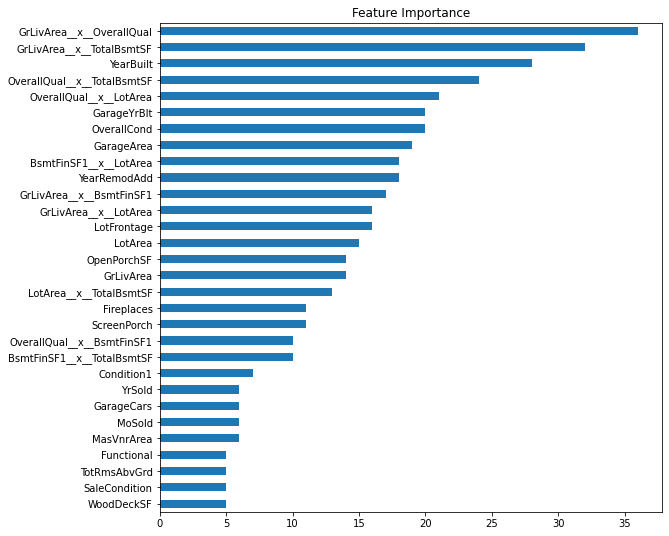

In [9]:
offline_pipe.get_feature_importances(k=k).iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Feature Importance',
);

### dask

In [10]:
import dask.dataframe as dd

In [11]:
data_dd = dd.read_parquet('data/house_prices.parquet').reset_index(drop=True)
y_dd = data_dd['SalePrice']
y_dd = y_dd.astype(float)
X_dd = data_dd.drop('SalePrice', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split.transform(X_dd, y_dd)

offline_pipe_dd = Pipeline(steps=offline_steps)
X_train_prepro_dd = offline_pipe_dd.fit_transform(
    X_train_dd, y_train_dd)
features_dd = list(X_train_prepro_dd.columns)

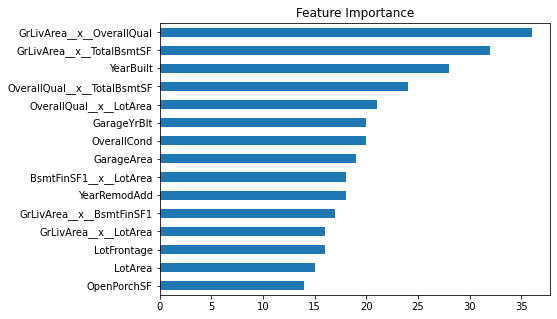

In [12]:
offline_pipe_dd.get_feature_importances(k=15)[::-1].plot(
    kind='barh', 
    figsize=(7, 5), 
    title='Feature Importance',
);

### koalas

In [13]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set('spark.executor.memory', '2g')
SparkContext(conf=conf)
from pyspark.ml.regression import RandomForestRegressor as RFRSpark
import databricks.koalas as ks
ks.set_option('compute.default_index_type', 'distributed-sequence')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/07 18:21:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/12/07 18:21:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/12/07 18:21:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [14]:
data = ks.read_parquet('data/house_prices.parquet', index_col='Id').reset_index(drop=True)
y_ks = data['SalePrice']
y_ks = y_ks.astype(float)
X_ks = data.drop('SalePrice', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_ks, X_test_ks, y_train_ks, y_test_ks = \
    train_test_split.transform(X_ks, y_ks)

model = RFRSpark(numTrees=50, maxDepth=3, labelCol=y_train.name, seed=0)
k = 30

offline_steps_ks = [
    BinRareCategories(min_ratio=0.2),
    ObjectImputer(strategy='constant', value='MISSING'),
    OrdinalEncoder(),
    NumericsImputer(strategy='constant', value=0),
    PolynomialFeatures(
        degree=2, 
        columns=polynomial_columns,
        interaction_only=True),
    SelectFromModel(model=model,k=k)
]
offline_pipe_ks = Pipeline(steps=offline_steps_ks)
X_train_prepro_ks = offline_pipe_ks.fit_transform(X_train_ks, y_train_ks)
features_ks = list(X_train_prepro_ks.columns)

21/12/07 18:21:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
21/12/07 18:23:49 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at org.codehaus.janino.UnitCompiler$1.visi

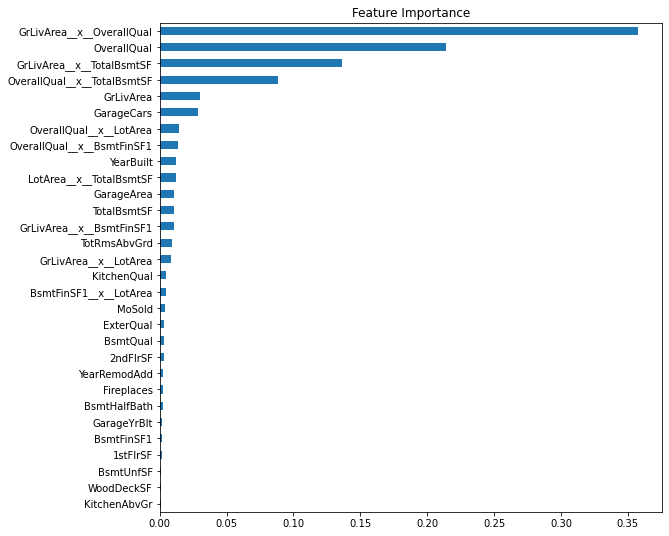

In [15]:
offline_pipe_ks.get_feature_importances(k=k).iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Feature Importance',
);

##### Selected features correlation

In [16]:
f'{int(100 * np.isin(features_dd, features).mean())}%'

'100%'

In [17]:
f'{int(100 * np.isin(features_ks, features).mean())}%'

'66%'

To compare the results between libraries, the features selected with Pandas will be chosen to build the production pipeline.

## production pipeline

Using the features from the Pandas pipeline to compare the results between the libraries later on.  

In [18]:
prod_steps = [
    BinRareCategories(min_ratio=0.2),
    ObjectImputer(strategy='constant', value='MISSING'),
    NumericsImputer(strategy='constant', value=0),
    OrdinalEncoder(),
    PolynomialFeatures(
        degree=2, 
        columns=polynomial_columns,
        interaction_only=True),
    KeepColumns(columns_to_keep=features)
]

### pandas

In [19]:
X_train_prod = X_train.copy()
X_train_prod_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro_np = prod_pipe.transform_numpy(
    X_train_prod.to_numpy())

#### check transform and transform numpy match

In [20]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_np),
    pd.DataFrame(X_train_prod_prepro.to_numpy())
)

### dask

In [21]:
X_train_prod_dd = X_train_dd.copy()
X_train_prod_dd_np = X_train_prod_dd.compute().to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_dd, y_train_dd)
X_train_prod_prepro_dd = prod_pipe.transform(X_train_prod_dd)
X_train_prod_prepro_dd_np = prod_pipe.transform_numpy(
    X_train_prod_dd.compute().to_numpy())

#### check transform and transform numpy match

In [22]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_dd_np),
    pd.DataFrame(X_train_prod_prepro_dd.compute().to_numpy())
)

### koalas

In [23]:
X_train_prod_ks = X_train_ks.copy()
X_train_prod_ks_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_ks, y_train_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_prod_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_prod_ks.to_numpy())

21/12/07 18:28:17 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:333)
	at org.codehaus.janino.Java$CompilationUnit.accept(Java.java:363)
	at org.codehaus.janino.UnitCompiler.compileUnit(UnitCompiler.java:333)
	

#### check transform and transform numpy match

In [24]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_ks_np),
    pd.DataFrame(X_train_prod_prepro_ks.to_pandas().to_numpy())
)

#### check pandas, dask, and koalas results match - production pipeline

In [25]:
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_dd_np)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)

## model building

### numpy

In [26]:
n_splits = 10
max_evals = 25
kfold = KFold(n_splits=n_splits)
space = {
    'max_depth': hp.quniform('max_depth', 2, 5, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
 }

model = LGBMRegressor(
    n_estimators=200,
    random_state=0,
)
hyper = HyperOpt(
    model=model,
    algo=tpe.suggest,
    scoring='r2',
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

100%|████████| 25/25 [00:15<00:00,  1.65trial/s, best loss: -0.8665538512292406]


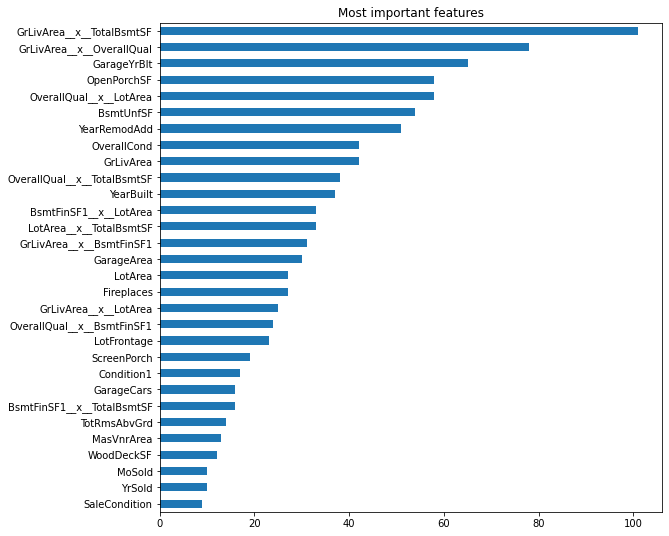

In [27]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Most important features',
);

In [28]:
hyper.history.sort_values('loss').head()

,colsample_bytree,learning_rate,max_depth,subsample,loss,status,id
23,0.279262,0.054401,3.0,0.880239,-0.866554,ok,23
22,0.260153,0.049922,3.0,0.908710,-0.865356,ok,22
16,0.222584,0.051712,4.0,0.998679,-0.864773,ok,16
20,0.215272,0.049877,3.0,0.990948,-0.864378,ok,20
18,0.870962,0.086478,2.0,0.443880,-0.863502,ok,18


In [29]:
model_np = copy.copy(hyper.model)
model_path = 'models/model_lgbm_house.dill'
with open(model_path, 'wb') as file:
    dill.dump(model_np, file)

### pandas

In [30]:
model_pd = copy.copy(model_np)
_ = model_pd.fit(X_train_prod_prepro, y_train)

### treelite

In [31]:
LGBMTreeliteDumper().dump(
    model=model_np, 
    toolchain='gcc',
    parallel_comp=4,
    model_path='./models/', 
    model_name='treelite_lgbm_house')

[18:28:36] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[18:28:38] /Users/travis/build/dmlc/treelite/src/compiler/ast_native.cc:703: Using ASTNativeCompiler
[18:28:38] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[18:28:38] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:92: Code generation finished. Writing code to files...
[18:28:38] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file recipe.json...
[18:28:38] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu3.c...
[18:28:38] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu2.c...
[18:28:38] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu1.c...
[18:28:38] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu0.c...
[18:

In [32]:
import treelite_runtime
model_tl = treelite_runtime.Predictor(
    './models/treelite_lgbm_house.so', verbose=False)

#### check the models prediction match

In [33]:
X_test_np = X_test.to_numpy()
y_pred_pd = model_pd.predict(
    prod_pipe.transform(X_train_prod))
y_pred_np = model.predict(
    prod_pipe.transform_numpy(X_train_prod_np.copy()))
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_train_prod_np.copy()
        )
    )
)
assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, y_pred_tl)

## model evaluation

In [34]:
X_test_prod = X_test.copy()
X_test_prod_np = X_test_prod.to_numpy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'R2 score: {r2_score(y_test, y_test_pred):.2f}'

'R2 score: 0.86'

## per-sample bechmarking

### pipeline only

In [35]:
x = X_test_prod.iloc[[1]]
xnp = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(xnp.copy())

62.7 ms ± 7.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.9 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x1699'

### pipeline & model

In [37]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(xnp.copy()))[0]
stats_tl = %timeit -o  model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(xnp.copy())))

91 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
269 µs ± 6.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
85.8 µs ± 2.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x338'

In [39]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x1061'